In [ ]:
# 오른쪽 아이콘 파일 클릭하고 드라이브모양 파일 클릭하면 이와 같은 코드가 생성됨! 꿀팁ㅎ
# from google.colab import drive
# drive.mount('/content/drive')

# 파일 오른쪽 클릭후 '경로복사'를 누르면 아래와같은 주소가 나옴!
# /content/gdrive/MyDrive/VGG4smalldataset_with_prediction.ipynb

In [ ]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
# 런타임 유형변경 -> python 3.x으로 바꿔주면 실행됨!

from google.colab import auth

# 구글 드라이브 mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 1. 홈 디렉토리에 datasets 폴더 생성 후, 그 안에 cats_and_dogs_small 폴더를 생성 합니다.
# 2. cats_and_dogs_small 안에 train, test, validation 폴더가 위치 하도록 압축을 풉니다.
%cd gdrive/My Drive/datasets/cats_and_dogs_small

[Errno 2] No such file or directory: 'gdrive/My Drive/datasets/cats_and_dogs_small'
/content


In [ ]:
!ls

drive  gdrive  sample_data


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator를 쓰는 이유 -> 데이터 파일이 하나의 파일로 되어있지 않으므로
# 배치단위로 생성해 보내줄 필요가 있는데 그것을 위해 사용함
# 두 종류로 사용할껀데 (traindatagenerator / testdatagenerator)

# image augmentation을 이용하면 이미작 부족할 때 하나의 이미지를 여러방향으로 뒤틀어 특징추출이 가능함

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
# 데이터셋의 수가 늘어나는것이 아니라 변형을 주는것 뿐
# https://keras.io/api/preprocessing/image/ 에서 이미지 제너레이터의 파라미터
# 각각의 역할을 확인 하면 좋음

# 영상을 랜덤하게 뽑아와서 네트워크에 던져주는 역할

test_datagen = ImageDataGenerator(rescale=1./255)
# 던져주기만 함


base_dir = '/content/gdrive/MyDrive/Colab Notebooks/ICT 이노베이션 스퀘어/05 11/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=12,
        class_mode='categorical')
# classmode = binary와 categorical 두가지가 있다.
# train이라는 폴더에 cats, dogs가 있다.
# (0)cats13장, (1)dogs7장 => 20장 
# categorical 11111110000000000000 binary 형태의 벡터로 받고
# binary 0 -> [1,0] / 1 -> [0,1] 로 표현이 됨


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=4,
        class_mode='categorical')

Found 121 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print ('Batch size:', data_batch.shape)
    print ('Label size:', labels_batch.shape)
    break

Batch size: (12, 224, 224, 3)
Label size: (12, 2)


In [ ]:
labels_batch
# 데이터 준비 끝

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
#  This code cell shows how to utilize VGG16 model by combining Dense layer at the end of the network 
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras import layers
from keras import models

VGGNet = VGG16()
VGGNet.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# We will not update VGG pre-trained model, only added Dense layers will be trained from the scratch
for layer in VGGNet.layers:
  layer.trainable = False
# frozen 시키기!

vgg_maxpool5 = VGGNet.get_layer('block5_pool').output
# classifier 전단계까지 전처리 해놓은 데이터
# Feature_Flattend = VGGNet.get_layer('flatten').output 라고 해도 됨


Feature_Flatten = Flatten()(vgg_maxpool5) # FLATTEN해주나 안해주나 같음.
dense = Dense(32, name='FC', activation='relu')(Feature_Flatten)
predictions = Dense(2,name='last', activation='softmax')(dense)

New_VGGmodel = Model(inputs=VGGNet.input, outputs=predictions)

New_VGGmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

New_VGGmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = New_VGGmodel.fit_generator(
    train_generator,
     validation_data=validation_generator, 
     validation_steps=10,
    steps_per_epoch=10,
    epochs=5
)

# train_generator의 batch마다 업데이트가 된다. 1epoch마다 업데이트가 되는게 아님.
# 매 epoch마다 validation set을 검증한다.

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 90s 7s/step - loss: 3.7723 - accuracy: 0.4759 - val_loss: 0.6885 - val_accuracy: 0.6750
Epoch 2/5
10/10 [==============================] - 68s 7s/step - loss: 0.7432 - accuracy: 0.4716 - val_loss: 0.6840 - val_accuracy: 0.5750
Epoch 3/5
10/10 [==============================] - 68s 7s/step - loss: 1.0650 - accuracy: 0.5796 - val_loss: 0.6380 - val_accuracy: 0.7750
Epoch 4/5
10/10 [==============================] - 72s 7s/step - loss: 0.5842 - accuracy: 0.7251 - val_loss: 0.6331 - val_accuracy: 0.8250
Epoch 5/5
10/10 [==============================] - 67s 7s/step - loss: 0.5928 - accuracy: 0.7706 - val_loss: 0.6075 - val_accuracy: 0.6750


In [ ]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [ ]:
pip install flickrapi

     |████████████████████████████████| 61kB 5.7MB/s 


In [ ]:
from flickrapi import FlickrAPI
# 무작위 임의의 데이터 가져오기위한 API

FLICKER_KEY = '505e8c2b05e8b5aa51766a43fc4bc7a7'
FLICKER_SECRET = '46b3ef2f43b04ac6'

flickr = FlickrAPI(FLICKER_KEY, FLICKER_SECRET, format='parsed-json')
extras='url_s'
cats = flickr.photos.search(text='dog', per_page=5, extras=extras)
photos = cats['photos']

In [ ]:
photos

{'page': 1,
 'pages': 37606,
 'perpage': 5,
 'photo': [{'farm': 66,
   'height_s': 160,
   'id': '51203541868',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '56996642@N05',
   'secret': '5b8333be44',
   'server': '65535',
   'title': '*',
   'url_s': 'https://live.staticflickr.com/65535/51203541868_5b8333be44_m.jpg',
   'width_s': 240},
  {'farm': 66,
   'height_s': 175,
   'id': '51203552318',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '191058887@N04',
   'secret': '16f5c0daff',
   'server': '65535',
   'title': 'Lucky.Dog.600.862086',
   'url_s': 'https://live.staticflickr.com/65535/51203552318_16f5c0daff_m.jpg',
   'width_s': 240},
  {'farm': 66,
   'height_s': 240,
   'id': '51204406950',
   'isfamily': 0,
   'isfriend': 0,
   'ispublic': 1,
   'owner': '71966785@N02',
   'secret': '62c528abc2',
   'server': '65535',
   'title': 'What a Face..',
   'url_s': 'https://live.staticflickr.com/65535/51204406950_62c528abc2_m.jpg',
   'width_s': 

In [ ]:
# import the necessary packages
import numpy as np
import urllib
import cv2

def url_to_image(url):
  # python 2
  # resp = urllib.urlopen(url)
  
  # python 3
  resp = urllib.request.urlopen(url)
  
  image = np.asarray(bytearray(resp.read()), dtype="uint8") # 들어온 데이터를 byte 단위로 끊어줌
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

In [ ]:
photos['photo'][0]['url_s']

'https://live.staticflickr.com/65535/51203541868_5b8333be44_m.jpg'

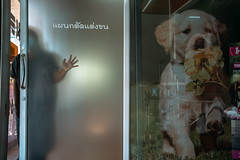

In [ ]:
from google.colab.patches import cv2_imshow

image_original_url = photos['photo'][0]['url_s']

image_temp = url_to_image(image_original_url)
cv2_imshow(image_temp)

In [ ]:
image_temp.shape

(160, 240, 3)

In [ ]:
resized_image = cv2.resize(image_temp, (224, 224))
print (resized_image.shape)

(224, 224, 3)


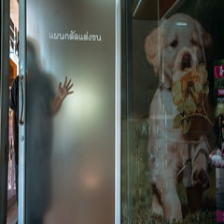

In [ ]:
cv2_imshow(resized_image)

In [ ]:
resized_image = np.expand_dims(resized_image, axis=0)
print (resized_image.shape)
# 이미지가 들어가려면 4차원으로 변경해줘야 함
# axis=0은 첫번째 축을 기준으로 한차원을 늘려라!라는 것 그래서 앞에 1 추가해 줌

(1, 224, 224, 3)


In [ ]:
result = New_VGGmodel.predict(resized_image)

In [ ]:
result

array([[0.9988644 , 0.00113564]], dtype=float32)

In [ ]:
# 0 -> [1, 0]
# 1 -> [0, 1]

In [ ]:
result = np.argmax(result)

In [ ]:
result
# cat이라고 맞춤??;;; 틀림ㅠㅠ

0

In [ ]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [ ]:
New_VGGmodel.save('MyVGGNet_210512.h5')

그래프 그리는것은 나중에 추가할 예정!